# Pset 1

## Question 1

In [126]:
import numpy as np
from numpy.linalg import matrix_power
from scipy.stats import norm, gaussian_kde, beta
import scipy.linalg as LA
import matplotlib
import matplotlib.pyplot as plt
from numba import vectorize, jit, njit, float64, prange


mat = np.loadtxt('/Users/alexweinberg/Desktop/BootCamp2018/ProbSets/Econ/Week2/matrix_data.txt')

lamb = LA.eigvals(mat) # compute eigenvalues
spec = np.absolute(lamb).max()
# r(X) = spec = 1.0044277694480632

In [127]:
def operator(v,X,i=int):
    '''
    ----------------------------------------
    Parameters:
    ----------------------------------------
    v    vector, n x 1
    X    matrix, n x 1
    i    integer, 1 x 1
    ----------------------------------------
    this value should converge to spec, r(X)
    ||X^i v||^(1/i) --> r(X)
    '''
    r = LA.norm(matrix_power(X,i) @ v) ** (1/i)
    dist = np.absolute(r - spec)
    return r, dist

j,jj = mat.shape
v = np.ones(j)

In [128]:
i = 1_000
r, dist = operator(v,mat,i)
dist

0.0012011304694321545

In [129]:
i = 100_000
r, dist = operator(v,mat,i)
dist

1.200420037306138e-05

## Question 2

In [130]:
@jit
def sim_ts(x0, ts_length=int):
    '''
    Simulate a time-series
    -----------------------
    x0 = initial value
    ts_length = number of times apply the difference equation
    '''
    x = x0 # initial guess
    for t in range(ts_length-1):
        # difference equation, g, is here
        x = 4 * x * (1 - x)

    return x

In [131]:
# Compile
sim_ts(0.4,10)

0.918969052370147

CPU times: user 2.69 s, sys: 15.6 ms, total: 2.7 s
Wall time: 2.73 s


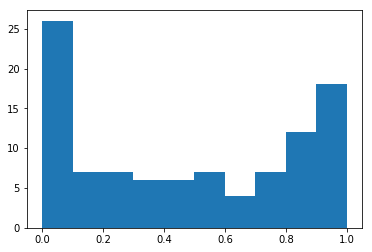

In [132]:
%%time
ts_length = 10_000_000
xknot = np.random.rand(100)
outcome = np.empty(xknot.size)

for i, x0 in enumerate(xknot):
    outcome[i] = sim_ts(x0, ts_length=ts_length)

plt.hist(outcome)

## Question 3

Because it is pointwise continuous, $$ \forall \epsilon \exists \delta,\text{s.t.} \quad |g(\hat{x}) - g(a)| < \epsilon \quad \text{when} \quad |\hat{x} - a| < \delta$$

Now, b/c limit, $\forall \epsilon$ we can choose T s.t. 
$$|g^t(x) - \hat{x}| < \epsilon \quad \text{when} \quad t > T $$

We choose T s.t. 
$$|g^t(x) - \hat{x}| < \delta $$
$$g(\lim_{t \rightarrow \infty}g^{t}(x)) = g(\hat{x}) = \hat{x}$$

# Pset 2

## Question 1

In [133]:
class KDE(object):

    def __init__(self, data=np.ndarray, bandwith=None):
        
        self.X = data
        self.n = data.size
        
        if not bandwith:
            self.h = self.compute_silv()
        else:
            self.h = bandwith
            
    def compute_silv(self):
        ''' Silverman's rule chooses optimal bandwith  '''
        sf = 1.06 * (self.n ** (-1/5)) * np.sqrt(np.var(self.X))
        return sf
    
    def f(self, x):
        
        K = norm.pdf
        
        mySum = K( (x - self.X) / self.h)
        val = (1 / (self.h*self.n)) * mySum.sum()
        return val
    
    def estimate_density(self, grid=np.linspace(0, 1, 1000)):
        density = np.empty_like(grid)
        
        for i,n in enumerate(grid):
            density[i] = self.f(n)
        
        return density

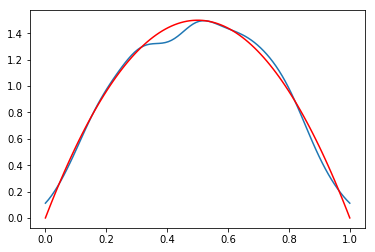

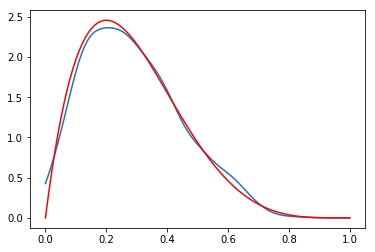

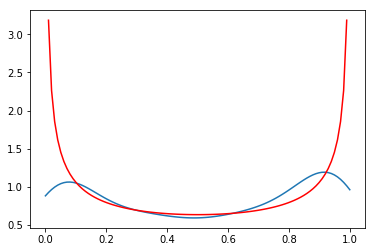

In [135]:
n = 1000
grid = np.linspace(0, 1, 100)

beta22 = np.random.beta(2, 2, size=(n,1))
kde1 = KDE(data=beta22)
estimate1 = kde1.estimate_density(grid=grid)

plt.plot(grid, estimate1, label='Estimate')
plt.plot(grid, beta.pdf(grid, 2, 2), label='True pdf')
plt.show()

beta25 = np.random.beta(2, 5, size=(n,1))
kde2 = KDE(data=beta25)
estimate2 = kde2.estimate_density(grid=grid)

plt.plot(grid, estimate2,)
plt.plot(grid, beta.pdf(grid, 2, 5),'label=True pdf')
plt.show()

beta0505 = np.random.beta(0.5, 0.5, size=(n,1))
kde3 = KDE(data=beta0505)
estimate3 = kde3.estimate_density(grid=grid)

plt.plot(grid, estimate3)
plt.plot(grid, beta.pdf(grid, 0.5, 0.5), label='True pdf')
plt.show()



#### COMMENT ####

# and beta(2,2) and beta(2,5) seem fairly accurate,similar.
# beta(0.5,0.5) was less accurate maybe because of small sample size



# Question 2

In [106]:
# Parameters
rho = 0.9
b = 0.0
sigma = 0.1
mu = -3
s = 0.2

def update(x, rho=rho, b=b, sigma=sigma):
    ''' Transition equation'''
    zeta = np.random.standard_normal()
    
    x_new = (rho * x) + b + (sigma * zeta)
    return x_new   

/Users/alexweinberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if sys.path[0] == '':
/Users/alexweinberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  del sys.path[0]


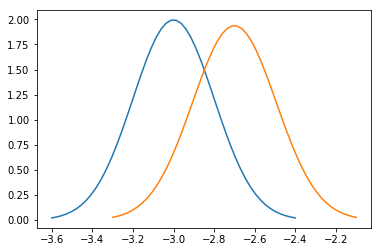

In [107]:
grid = np.linspace(0,1,100)
psi = norm.pdf(grid, loc=mu, scale=s**2)

# construct 3sigma domains for x_t and x_t+1
domainX = np.linspace(mu - 3*(s), mu + 3*(s))
domainY = np.linspace(rho*mu + b - 3*(s), rho*mu + b + 3*(s))

# parameters for psi_t+1 distribution
avg = rho*mu + b
s2 = (rho**2)*(s**2) + (sigma**2)

plt.plot(domainX, matplotlib.mlab.normpdf(domainX, mu, s))
plt.plot(domainY, matplotlib.mlab.normpdf(domainY, avg, np.sqrt(s2)))


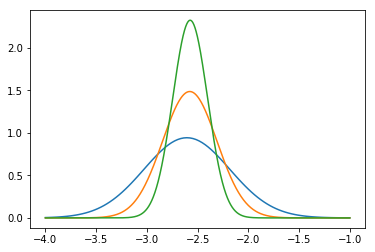

In [112]:
ngrid = [100,1000,10_000]
for n in ngrid:
    initial = np.random.normal(mu, s**2 , n)

    new_dist = update(initial)
    kde = KDE(new_dist)
    
    grid = np.linspace(-4,-1,n)
    kde.plot_density(grid=grid)

# Question 3

**WTS:** $$\text{if} \quad r(A) < 1 \quad \text{then} \quad A^k \rightarrow 0 \\
i.e. \quad ||A^k - 0|| < \epsilon$$

**PF:**

Spectral norm is defined as $$r(A) = sup\{\frac{||Ax||}{||x||} : x \in R^k, x \neq0 \}$$

So by assumption, $$\frac{||Ax||}{||x||} < 1 \quad \forall x$$

We know, $$ ||Ax|| \leq ||A||\cdot||x||$$
Which gives us $$ ||A|| < 1 $$

So now we take, $$||A^k -0|| = ||A^k|| \leq ||A||^k$$
And from calculus we know that because, $$ ||A|| < 1 \\ \forall \epsilon \quad \exists K \quad s.t. \quad  ||A||^k < \epsilon \quad \text{when} \quad k>K$$

Putting those together, for any epsilon if k large enough we have 

$$||A^k|| \leq ||A||^k < \epsilon$$